## ImportsConcatDataset

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

ModuleNotFoundError: No module named 'tensorboard'

## Data preprocessings

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split

In [3]:
class Genericsplit:
    def __init__(self,data,labels,train_size,val_size,test_size,random_state):
        self.data=data
        self.labels=labels
        self.train_portion=train_size
        self.val_portion=val_size
        self.test_portion=test_size
        self.random_state=random_state
        
    def partitioning(self):
        train_val_data,test_data, train_val_labels,test_labels= train_test_split(self.data,self.labels,
                                                                                 test_size=self.test_portion,random_state=self.random_state)
        train_data,val_data, train_labels,val_labels= train_test_split(train_val_data,train_val_labels,
                                                                       test_size=self.val_portion,random_state=self.random_state)
        
        return {'Train' : [train_data,train_labels], 'Val' : [val_data,val_labels], 'Test': [test_data, test_labels]}
    
    
    
        

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class GenericDataset(Dataset):
    def __init__(self, data, labels=None, batch_size=64, shuffle=True, drop_last=False, pin_memory=True, num_workers=1):
        self.data = data
        self.labels = labels
        self.transform = None
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.pin_memory = pin_memory
        self.num_workers = num_workers
        
        self.data_loader = None
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        
        if self.transform:
            sample = self.transform(sample)
            
        if self.labels is not None:
            label = self.labels[idx]  # Corrected from 'lebel' to 'label'
            return sample, label
        else:
            return sample, None
        
    def get_data_loader(self, generic_data):
        self.data_loader = DataLoader(generic_data, batch_size=self.batch_size, shuffle=self.shuffle, num_workers=self.num_workers, 
                                      drop_last=self.drop_last, pin_memory=self.pin_memory)
        return self.data_loader
    
    def set_transform(self, lst_transformation):
        self.transform = transforms.Compose(lst_transformation)


## CIFAR-10 Dataset

In [5]:
from torch.utils.data import ConcatDataset

train_dataset= torchvision.datasets.CIFAR10(root='/kaggle/working/', train=True, download=True)
test_dataset= torchvision.datasets.CIFAR10(root='/kaggle/working/', train=False, download=True)

cifar10=ConcatDataset([train_dataset, test_dataset])
data, labels = zip(*cifar10)

100%|██████████| 170498071/170498071 [00:03<00:00, 48384366.35it/s]


Extracting /kaggle/working/cifar-10-python.tar.gz to /kaggle/working/
Files already downloaded and verified


 ***Data partioning and generic dataset***

In [6]:
gen_split=Genericsplit(data, labels, 48000, 6000, 6000, random_state=42)
data_partitions=gen_split.partitioning()

In [7]:
train_data = GenericDataset(data_partitions["Train"][0], labels=data_partitions["Train"][1], batch_size=128,
                            shuffle=True, drop_last=False, pin_memory=True, num_workers=1)
val_data= GenericDataset(data_partitions['Val'][0], labels=data_partitions['Val'][1], batch_size= 128, shuffle=False, 
                           drop_last=False, pin_memory=True, num_workers=1)
test_data= GenericDataset(data_partitions['Test'][0], labels=data_partitions['Test'][1], batch_size= 128, shuffle=False, 
                           drop_last=False, pin_memory=True, num_workers=1)

print("size of the training dataset: ", len(train_data))
print("size of the validation dataset: ", len(val_data))
print("size of the test dataset: ", len(test_data))

size of the training dataset:  48000
size of the validation dataset:  6000
size of the test dataset:  6000


***data loading and preprocessing***

In [8]:
train_transform_list= [transforms.RandomCrop(32,padding=4), transforms.RandomHorizontalFlip(), transforms.ToTensor(), 
                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]
val_transform_list= [transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]
test_transform_list= [transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]

train_data.set_transform(train_transform_list)
test_data.set_transform(test_transform_list)
val_data.set_transform(val_transform_list)

train_loader=train_data.get_data_loader(train_data)
val_loader=val_data.get_data_loader(val_data)
test_loader=test_data.get_data_loader(test_data)

## Model Design

In [9]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        
        self.conv1= nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=(2,2), padding=1)
        self.bn1=nn.BatchNorm2d(64)
        self.relu1=nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=(2,2), padding=1)
        self.bn2=nn.BatchNorm2d(128)
        self.relu2=nn.ReLU(inplace=True)
        
        self.conv3=nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=(2,2), padding=1)
        self.bn3=nn.BatchNorm2d(256)
        self.relu3=nn.ReLU(inplace=True)
        
        
        self.global_avg_pooling = lambda x: torch.mean(x, dim=[2,3])
        
        self.fc1=nn.Linear(256,64)
        self.relu4=nn.ReLU(inplace=True)
        
        self.dropout= nn.Dropout(p=0.25)
        
        self.fc2=nn.Linear(64,10)
        
    def forward(self,x):
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu1(x)
        
        x=self.conv2(x)
        x=self.bn2(x)
        x=self.relu2(x)
        
        x=self.conv3(x)
        x=self.bn3(x)
        x=self.relu3(x)
        
        x = self.global_avg_pooling(x)

        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)

        x = self.fc2(x)
        
        return x
        

## Loss function and regularlization

In [10]:
class GenericLoss(nn.Module):
    
    def __init__(self, model, reg_lambda):
        super(GenericLoss, self).__init__()
        self.model = model
        self.reg_lambda = reg_lambda
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, outputs, targets):
        ce_loss = self.criterion(outputs, targets)
        l2_loss = sum(param.pow(2.0).sum() for param in self.model.parameters())
        loss = ce_loss + self.reg_lambda * l2_loss
        return loss

In [11]:
class EarlyStopping:
    
    def __init__(self, filepath, patience=10, minimize=True):
        self.patience = patience
        self.filepath = filepath
        self.minimize = minimize

        if not os.path.exists(filepath):
            os.makedirs(filepath)
            print(f"Directory not existed! '{filepath}' created.")
        else:
            print(f"Directory '{filepath}' already exists.")
        
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_metric, model):
        if self.minimize:
            score = -val_metric
        else:
            score = val_metric
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                print("Early stopping")
        else:
            self.best_score = score
            self.counter = 0
        
    def save_checkpoint(self, model):
        print("Save the model and its state with the current best validation metric: ", self.best_score) 
        torch.save(model.state_dict(), self.filepath +'/checkpoint.pt')

## Model training

In [12]:
class Trainer:

    def __init__(self, model, train_loader, loss_func, optimizer, classes, visualizer):
        self.model = model
        self.train_loader = train_loader 
        self.loss_func = loss_func
        self.optimizer = optimizer
        self.classes = classes
        self.visualizer = visualizer
    
    def train(self, epoch):
        total = 0
        true_pred = 0
        max_images = 6
        running_loss = 0.0

        self.model.train()
        
        if torch.cuda.is_available():
            self.model =self.model.cuda()
         
        for batch_idx, (inputs, targets) in enumerate(self.train_loader):
            
            if torch.cuda.is_available():
                inputs, targets = inputs.cuda(), targets.cuda()
            
            self.optimizer.zero_grad()
            
            outputs = self.model(inputs)

            loss = self.loss_func(outputs, targets)
            
            loss.backward()
            
            self.optimizer.step()
            
            running_loss += loss.item()

            _, predicted = outputs.max(1)
            
            total += targets.size(0)
            
            true_pred += predicted.eq(targets).sum().item()

            if batch_idx % 128 == 0:
                print(f'Epoch [{epoch+1}], Iteration [{batch_idx+1}], Loss: {loss.item():.4f}')
            
        print(f'Epoch [{epoch+1}], Iteration [{batch_idx+1}], Loss: {loss.item():.4f}')
        writer.add_figure('train: PRED vs. GT', self.visualizer.plot_classes_preds(outputs, inputs, targets, self.classes, max_images), global_step=epoch)
            
        epoch_loss = running_loss / len(self.train_loader)
        
        epoch_acc = 100.0 * true_pred / total
        
        writer.add_scalar('training loss', epoch_loss, epoch)
        writer.add_scalar('training accuracy', epoch_acc, epoch)
        
        return epoch_loss, epoch_acc   

## Model evaluation

In [13]:
class Evaluator:

    def __init__(self, split, model, eval_loader, loss_func, classes, visualizer):
        self.split = split
        self.model = model
        self.eval_loader = eval_loader
        self.loss_func = loss_func
        self.classes = classes
        self.visualizer = visualizer
    
    def evaluate(self, epoch=0):
        total = 0
        true_pred = 0
        max_images = 6
        eval_loss = 0.0

        self.model.eval()
        
        if torch.cuda.is_available():
            self.model = self.model.cuda()
                    
        with torch.no_grad():
            
            for inputs, targets in self.eval_loader:
    
                if torch.cuda.is_available():
                    inputs, targets = inputs.cuda(), targets.cuda()
                
                outputs = self.model(inputs)
                
                loss = self.loss_func(outputs, targets)
                
                eval_loss += loss.item()
                
                _, predicted = outputs.max(1)
                
                total += targets.size(0)
                
                true_pred += predicted.eq(targets).sum().item()

        writer.add_figure(self.split+': PRED vs. GT', self.visualizer.plot_classes_preds(outputs, inputs, targets, self.classes, max_images), global_step=epoch)
                
        epoch_loss = eval_loss / len(self.eval_loader)
        
        epoch_acc = true_pred / total * 100.0
        
        writer.add_scalar(self.split + ' loss', epoch_loss, epoch)
        writer.add_scalar(self.split + ' accuracy', epoch_acc, epoch)
        
        return epoch_loss, epoch_acc

## Visualizer

In [14]:
class Visualizer:

    def __init__(self):
        pass

    # helper function to show an image - taken from https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html, 2.7.24, no changes were made
    def matplotlib_imshow(self, img, one_channel=False):

        if one_channel:
            img = img.mean(dim=0)
        img = img / 2 + 0.5
        img=img.cpu()
        npimg = img.numpy()
        if one_channel:
            plt.imshow(npimg, cmap="Greys")
        else:
            plt.imshow(np.transpose(npimg, (1, 2, 0)))

    # helper function - taken from https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html, 2.7.24, modified
    def images_to_probs(self, model_outputs):
        '''
        Generates predictions and corresponding probabilities from a trained
        network and a list of images
        '''
        _, preds_tensor = torch.max(model_outputs, 1)
       
        probs = F.softmax(model_outputs, dim=1)
       
        return preds_tensor, probs
    
    # helper function - taken from https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html, 2.7.24, modified
    def plot_classes_preds(self, model_outputs, images, labels, classes, max_img):
        '''
        Generates matplotlib Figure using a trained network, along with images
        and labels from a batch, that shows the network's top prediction along
        with its probability, alongside the actual label, coloring this
        information based on whether the prediction was correct or not.
        Uses the "images_to_probs" function.
        '''
        preds, probs = self.images_to_probs(model_outputs)
        
        probs = probs.detach()
        batch_size = preds.shape[0]
        if batch_size >= max_img:
            max_subs = max_img
    
        fig = plt.figure()
        for idx in np.arange(max_subs):   
            ax = fig.add_subplot(1, max_subs, idx+1, xticks=[], yticks=[])

            self.matplotlib_imshow(torch.clip(images[idx], 0, 1), one_channel=False)
            
            ax.set_title("{0}, {1:.1f}%\n(label: {2})".format
            (
                classes[preds[idx].item()],
                probs[idx][preds[idx].item()] * 100.0,
                classes[labels[idx].item()]
            ),
            fontsize=8,
            color=("green" if preds[idx]==labels[idx].item() else "red"))
        plt.tight_layout()
        plt.show()
        return fig       

## Model Training procedure
+ Build a model
+ create the loss
+ setting optimizer
+ initializing the summary writer to document training in tensorboard
+ finalize the training loop

Directory not existed! '/home/be/Desktop/PyTorch/runs//checkpoints/' created.


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [1], Iteration [1], Loss: 2.3651
Epoch [1], Iteration [129], Loss: 1.7648
Epoch [1], Iteration [257], Loss: 1.6442


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [1], Iteration [375], Loss: 1.6357


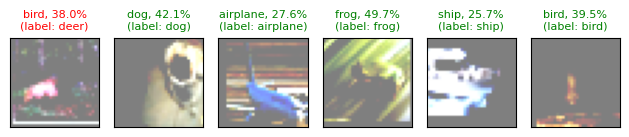

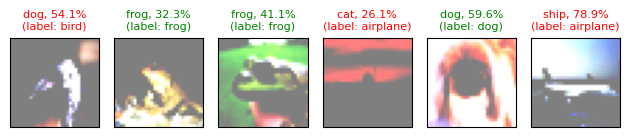

Epoch [1/100], Train Loss: 1.7336, Train Acc: 37.29%, Val Loss: 1.4797, Val Acc: 48.02%
Save the model and its state with the current best validation metric:  48.016666666666666
Epoch [2], Iteration [1], Loss: 1.4968
Epoch [2], Iteration [129], Loss: 1.4287
Epoch [2], Iteration [257], Loss: 1.5540
Epoch [2], Iteration [375], Loss: 1.2784


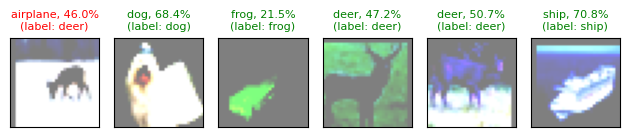

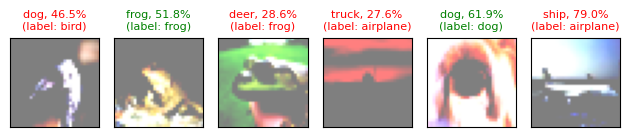

Epoch [2/100], Train Loss: 1.4565, Train Acc: 49.72%, Val Loss: 1.3704, Val Acc: 53.42%
Save the model and its state with the current best validation metric:  53.41666666666667
Epoch [3], Iteration [1], Loss: 1.4800
Epoch [3], Iteration [129], Loss: 1.3502
Epoch [3], Iteration [257], Loss: 1.3166
Epoch [3], Iteration [375], Loss: 1.4048


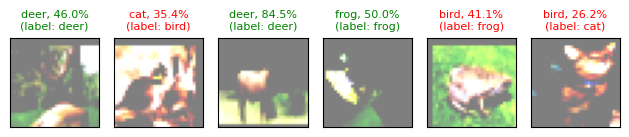

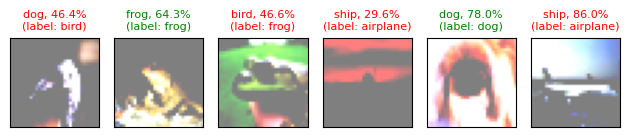

Epoch [3/100], Train Loss: 1.3461, Train Acc: 54.53%, Val Loss: 1.2933, Val Acc: 55.78%
Save the model and its state with the current best validation metric:  55.78333333333333
Epoch [4], Iteration [1], Loss: 1.2443
Epoch [4], Iteration [129], Loss: 1.2219
Epoch [4], Iteration [257], Loss: 1.2093
Epoch [4], Iteration [375], Loss: 1.3194


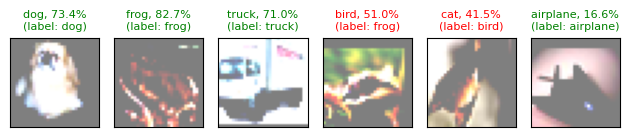

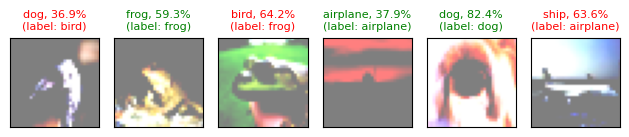

Epoch [4/100], Train Loss: 1.2699, Train Acc: 57.75%, Val Loss: 1.2214, Val Acc: 58.82%
Save the model and its state with the current best validation metric:  58.81666666666666
Epoch [5], Iteration [1], Loss: 1.2366
Epoch [5], Iteration [129], Loss: 1.3892
Epoch [5], Iteration [257], Loss: 1.1985
Epoch [5], Iteration [375], Loss: 1.1679


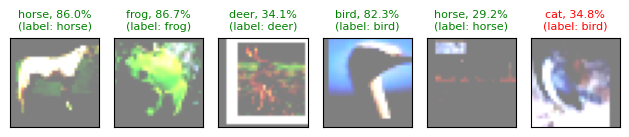

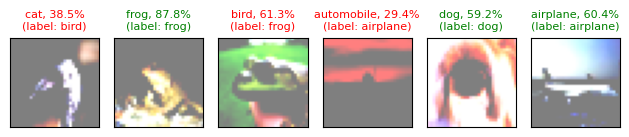

Epoch [5/100], Train Loss: 1.2228, Train Acc: 60.00%, Val Loss: 1.2160, Val Acc: 60.85%
Save the model and its state with the current best validation metric:  60.85
Epoch [6], Iteration [1], Loss: 1.3015
Epoch [6], Iteration [129], Loss: 1.1909
Epoch [6], Iteration [257], Loss: 0.9564
Epoch [6], Iteration [375], Loss: 0.9659


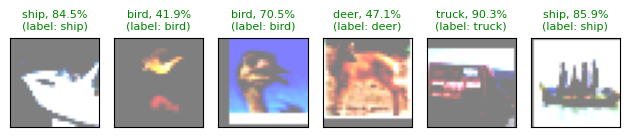

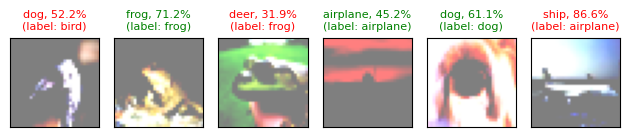

Epoch [6/100], Train Loss: 1.1790, Train Acc: 61.80%, Val Loss: 1.1278, Val Acc: 62.88%
Save the model and its state with the current best validation metric:  62.88333333333333
Epoch [7], Iteration [1], Loss: 1.1143
Epoch [7], Iteration [129], Loss: 1.1327
Epoch [7], Iteration [257], Loss: 1.2440
Epoch [7], Iteration [375], Loss: 1.1824


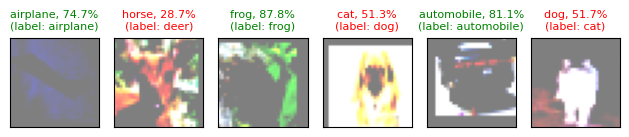

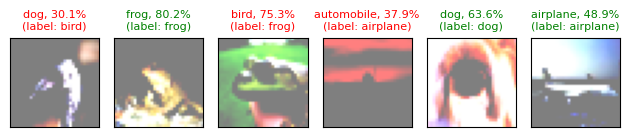

Epoch [7/100], Train Loss: 1.1491, Train Acc: 63.02%, Val Loss: 1.1254, Val Acc: 63.78%
Save the model and its state with the current best validation metric:  63.78333333333334
Epoch [8], Iteration [1], Loss: 1.1686
Epoch [8], Iteration [129], Loss: 0.9990
Epoch [8], Iteration [257], Loss: 1.2792
Epoch [8], Iteration [375], Loss: 1.0792


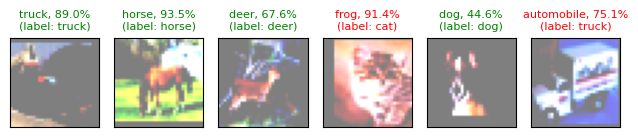

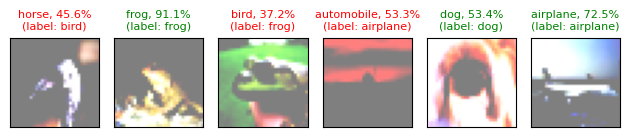

Epoch [8/100], Train Loss: 1.1187, Train Acc: 64.36%, Val Loss: 1.1043, Val Acc: 65.00%
Save the model and its state with the current best validation metric:  65.0
Epoch [9], Iteration [1], Loss: 1.1293
Epoch [9], Iteration [129], Loss: 1.0580
Epoch [9], Iteration [257], Loss: 1.2041
Epoch [9], Iteration [375], Loss: 1.0477


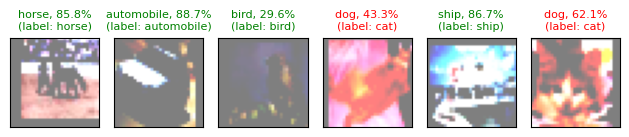

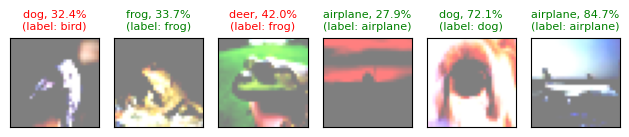

Epoch [9/100], Train Loss: 1.0962, Train Acc: 65.55%, Val Loss: 1.1452, Val Acc: 63.72%
Save the model and its state with the current best validation metric:  65.0
Epoch [10], Iteration [1], Loss: 1.1236
Epoch [10], Iteration [129], Loss: 1.0745
Epoch [10], Iteration [257], Loss: 0.9885
Epoch [10], Iteration [375], Loss: 1.0264


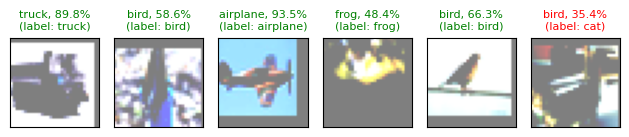

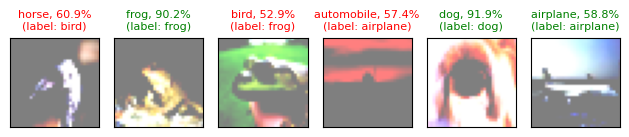

Epoch [10/100], Train Loss: 1.0755, Train Acc: 66.17%, Val Loss: 1.0419, Val Acc: 67.23%
Save the model and its state with the current best validation metric:  67.23333333333333
Epoch [11], Iteration [1], Loss: 0.9210
Epoch [11], Iteration [129], Loss: 0.8945
Epoch [11], Iteration [257], Loss: 1.0442
Epoch [11], Iteration [375], Loss: 1.0847


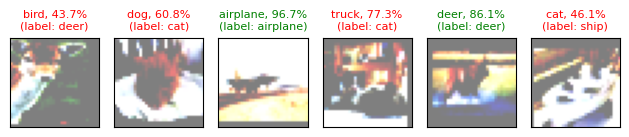

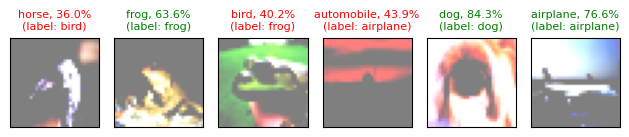

Epoch [11/100], Train Loss: 1.0527, Train Acc: 67.65%, Val Loss: 1.0433, Val Acc: 67.58%
Save the model and its state with the current best validation metric:  67.58333333333333
Epoch [12], Iteration [1], Loss: 1.0357
Epoch [12], Iteration [129], Loss: 0.9915
Epoch [12], Iteration [257], Loss: 1.1062
Epoch [12], Iteration [375], Loss: 0.9008


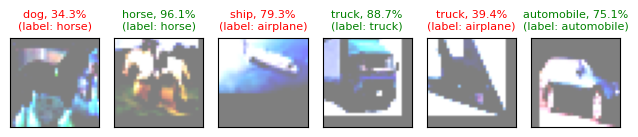

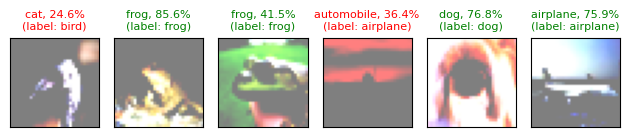

Epoch [12/100], Train Loss: 1.0393, Train Acc: 67.95%, Val Loss: 1.0349, Val Acc: 67.68%
Save the model and its state with the current best validation metric:  67.68333333333332
Epoch [13], Iteration [1], Loss: 1.0844
Epoch [13], Iteration [129], Loss: 0.9182
Epoch [13], Iteration [257], Loss: 1.0901
Epoch [13], Iteration [375], Loss: 1.0362


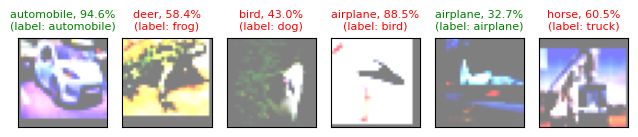

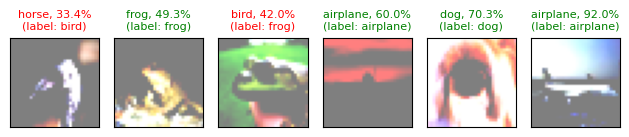

Epoch [13/100], Train Loss: 1.0167, Train Acc: 69.31%, Val Loss: 1.1469, Val Acc: 64.98%
Save the model and its state with the current best validation metric:  67.68333333333332
Epoch [14], Iteration [1], Loss: 0.9964
Epoch [14], Iteration [129], Loss: 1.0584
Epoch [14], Iteration [257], Loss: 0.9705
Epoch [14], Iteration [375], Loss: 0.8930


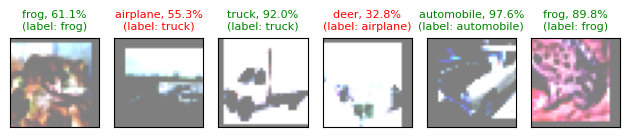

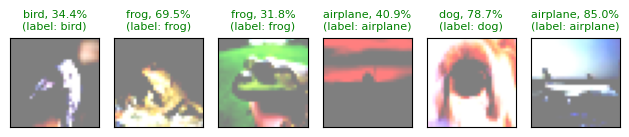

Epoch [14/100], Train Loss: 1.0011, Train Acc: 69.76%, Val Loss: 0.9569, Val Acc: 70.72%
Save the model and its state with the current best validation metric:  70.71666666666667
Epoch [15], Iteration [1], Loss: 0.8867
Epoch [15], Iteration [129], Loss: 1.3727
Epoch [15], Iteration [257], Loss: 0.9673
Epoch [15], Iteration [375], Loss: 0.8875


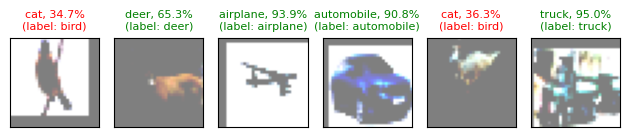

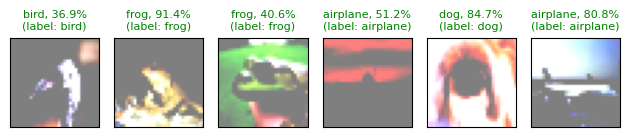

Epoch [15/100], Train Loss: 0.9893, Train Acc: 70.49%, Val Loss: 1.0222, Val Acc: 69.68%
Save the model and its state with the current best validation metric:  70.71666666666667
Epoch [16], Iteration [1], Loss: 0.9780
Epoch [16], Iteration [129], Loss: 1.0596
Epoch [16], Iteration [257], Loss: 0.9160
Epoch [16], Iteration [375], Loss: 0.8209


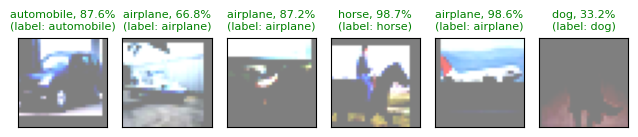

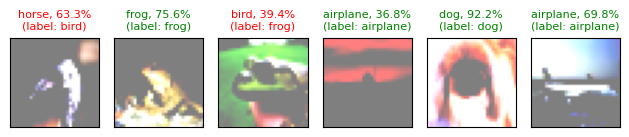

Epoch [16/100], Train Loss: 0.9809, Train Acc: 70.84%, Val Loss: 0.9505, Val Acc: 71.53%
Save the model and its state with the current best validation metric:  71.53333333333333
Epoch [17], Iteration [1], Loss: 0.9919
Epoch [17], Iteration [129], Loss: 1.0544
Epoch [17], Iteration [257], Loss: 1.1887
Epoch [17], Iteration [375], Loss: 1.0674


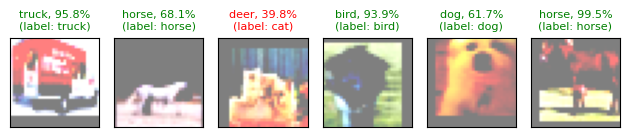

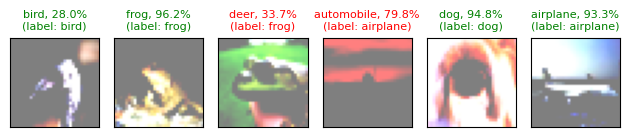

Epoch [17/100], Train Loss: 0.9646, Train Acc: 71.68%, Val Loss: 0.9603, Val Acc: 70.80%
Save the model and its state with the current best validation metric:  71.53333333333333
Epoch [18], Iteration [1], Loss: 1.0244
Epoch [18], Iteration [129], Loss: 0.8974
Epoch [18], Iteration [257], Loss: 0.8098
Epoch [18], Iteration [375], Loss: 0.9469


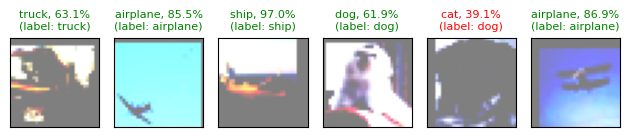

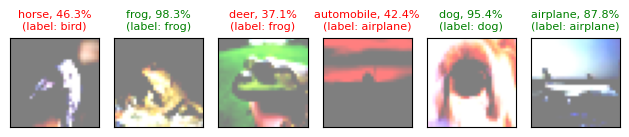

Epoch [18/100], Train Loss: 0.9540, Train Acc: 71.84%, Val Loss: 0.9431, Val Acc: 72.52%
Save the model and its state with the current best validation metric:  72.51666666666667
Epoch [19], Iteration [1], Loss: 1.0556
Epoch [19], Iteration [129], Loss: 0.9767
Epoch [19], Iteration [257], Loss: 0.9789
Epoch [19], Iteration [375], Loss: 0.9003


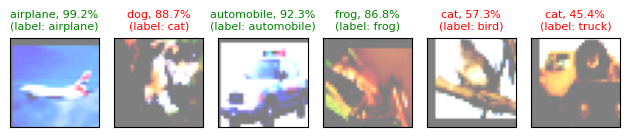

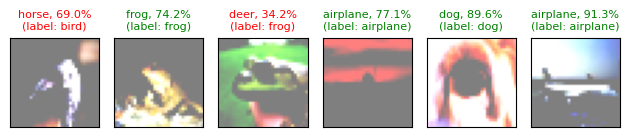

Epoch [19/100], Train Loss: 0.9392, Train Acc: 72.62%, Val Loss: 0.9680, Val Acc: 71.48%
Save the model and its state with the current best validation metric:  72.51666666666667
Epoch [20], Iteration [1], Loss: 1.0456
Epoch [20], Iteration [129], Loss: 0.7916
Epoch [20], Iteration [257], Loss: 0.9313
Epoch [20], Iteration [375], Loss: 1.0182


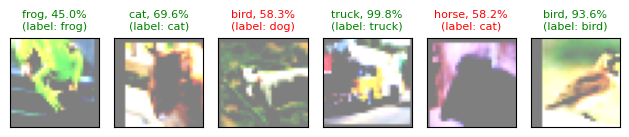

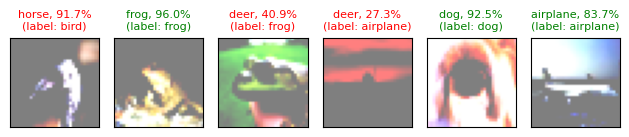

Epoch [20/100], Train Loss: 0.9339, Train Acc: 72.89%, Val Loss: 0.9489, Val Acc: 72.45%
Save the model and its state with the current best validation metric:  72.51666666666667
Epoch [21], Iteration [1], Loss: 0.9932
Epoch [21], Iteration [129], Loss: 0.8737
Epoch [21], Iteration [257], Loss: 1.1275
Epoch [21], Iteration [375], Loss: 0.9514


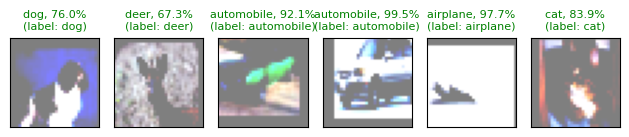

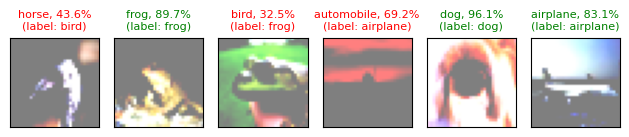

Epoch [21/100], Train Loss: 0.9298, Train Acc: 73.19%, Val Loss: 0.9578, Val Acc: 72.02%
Save the model and its state with the current best validation metric:  72.51666666666667
Epoch [22], Iteration [1], Loss: 0.8544
Epoch [22], Iteration [129], Loss: 0.9940
Epoch [22], Iteration [257], Loss: 0.9359
Epoch [22], Iteration [375], Loss: 0.8625


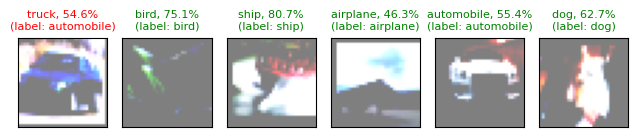

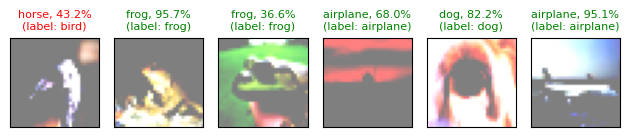

Epoch [22/100], Train Loss: 0.9128, Train Acc: 74.10%, Val Loss: 0.9089, Val Acc: 73.62%
Save the model and its state with the current best validation metric:  73.61666666666666
Epoch [23], Iteration [1], Loss: 0.9998
Epoch [23], Iteration [129], Loss: 0.9263
Epoch [23], Iteration [257], Loss: 0.7809
Epoch [23], Iteration [375], Loss: 0.8505


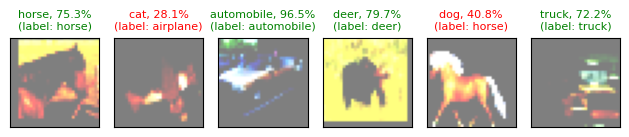

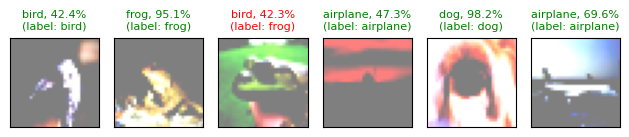

Epoch [23/100], Train Loss: 0.9071, Train Acc: 74.21%, Val Loss: 0.9296, Val Acc: 72.58%
Save the model and its state with the current best validation metric:  73.61666666666666
Epoch [24], Iteration [1], Loss: 0.9025
Epoch [24], Iteration [129], Loss: 1.0412
Epoch [24], Iteration [257], Loss: 0.8325
Epoch [24], Iteration [375], Loss: 1.0383


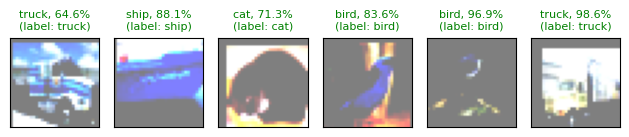

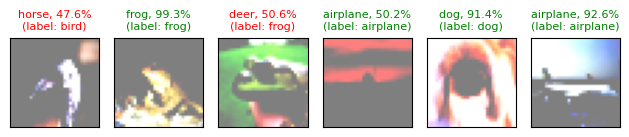

Epoch [24/100], Train Loss: 0.9021, Train Acc: 74.62%, Val Loss: 0.8895, Val Acc: 74.37%
Save the model and its state with the current best validation metric:  74.36666666666667
Epoch [25], Iteration [1], Loss: 0.9226
Epoch [25], Iteration [129], Loss: 0.8368
Epoch [25], Iteration [257], Loss: 0.8066
Epoch [25], Iteration [375], Loss: 0.8952


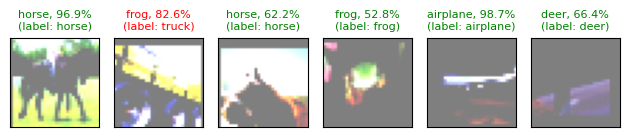

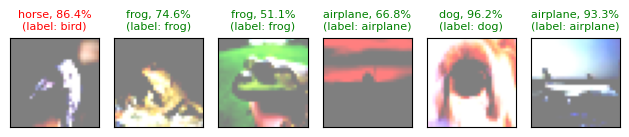

Epoch [25/100], Train Loss: 0.8923, Train Acc: 74.67%, Val Loss: 0.8962, Val Acc: 73.92%
Save the model and its state with the current best validation metric:  74.36666666666667
Epoch [26], Iteration [1], Loss: 1.0770
Epoch [26], Iteration [129], Loss: 0.9874
Epoch [26], Iteration [257], Loss: 0.9786
Epoch [26], Iteration [375], Loss: 0.8141


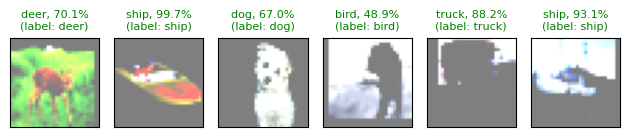

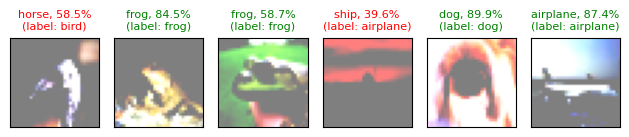

Epoch [26/100], Train Loss: 0.8917, Train Acc: 74.97%, Val Loss: 0.9166, Val Acc: 73.68%
Save the model and its state with the current best validation metric:  74.36666666666667
Epoch [27], Iteration [1], Loss: 0.8025
Epoch [27], Iteration [129], Loss: 0.9207
Epoch [27], Iteration [257], Loss: 0.8735
Epoch [27], Iteration [375], Loss: 0.8738


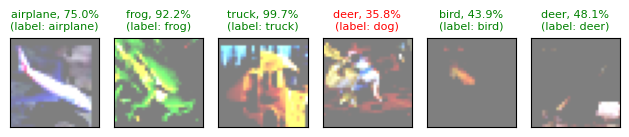

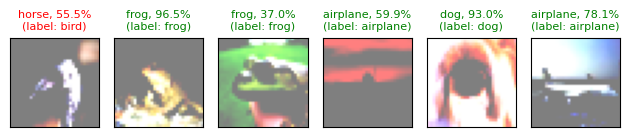

Epoch [27/100], Train Loss: 0.8829, Train Acc: 75.31%, Val Loss: 0.8929, Val Acc: 74.52%
Save the model and its state with the current best validation metric:  74.51666666666667
Epoch [28], Iteration [1], Loss: 0.8324
Epoch [28], Iteration [129], Loss: 0.9271
Epoch [28], Iteration [257], Loss: 0.9220
Epoch [28], Iteration [375], Loss: 0.8111


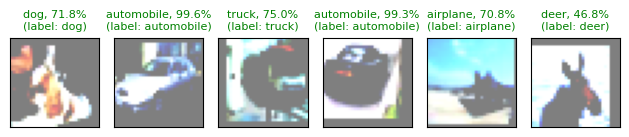

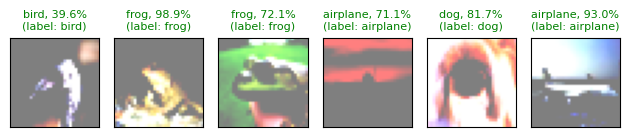

Epoch [28/100], Train Loss: 0.8748, Train Acc: 75.50%, Val Loss: 0.9853, Val Acc: 72.43%
Save the model and its state with the current best validation metric:  74.51666666666667
Epoch [29], Iteration [1], Loss: 0.8298
Epoch [29], Iteration [129], Loss: 0.7712
Epoch [29], Iteration [257], Loss: 1.0103
Epoch [29], Iteration [375], Loss: 0.9950


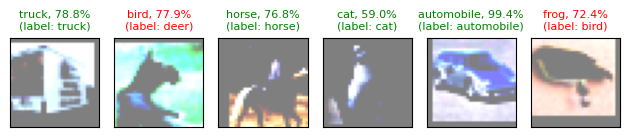

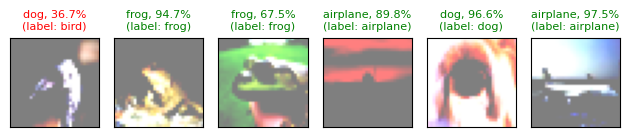

Epoch [29/100], Train Loss: 0.8754, Train Acc: 75.58%, Val Loss: 0.8528, Val Acc: 75.92%
Save the model and its state with the current best validation metric:  75.91666666666667
Epoch [30], Iteration [1], Loss: 0.8882
Epoch [30], Iteration [129], Loss: 0.8644
Epoch [30], Iteration [257], Loss: 0.9038
Epoch [30], Iteration [375], Loss: 1.0338


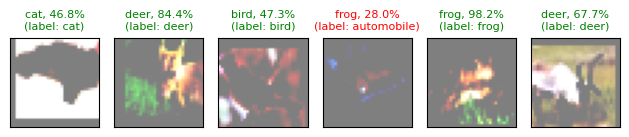

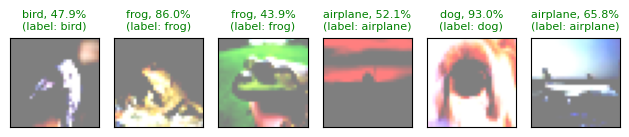

Epoch [30/100], Train Loss: 0.8672, Train Acc: 76.15%, Val Loss: 0.9501, Val Acc: 73.15%
Save the model and its state with the current best validation metric:  75.91666666666667
Epoch [31], Iteration [1], Loss: 0.8933
Epoch [31], Iteration [129], Loss: 0.8978
Epoch [31], Iteration [257], Loss: 0.7608
Epoch [31], Iteration [375], Loss: 1.0387


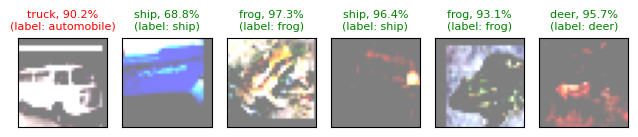

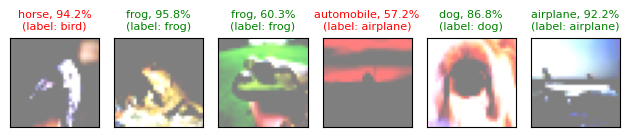

Epoch [31/100], Train Loss: 0.8661, Train Acc: 76.05%, Val Loss: 0.9388, Val Acc: 73.23%
Save the model and its state with the current best validation metric:  75.91666666666667
Epoch [32], Iteration [1], Loss: 0.9009
Epoch [32], Iteration [129], Loss: 0.8445
Epoch [32], Iteration [257], Loss: 0.8376
Epoch [32], Iteration [375], Loss: 0.9231


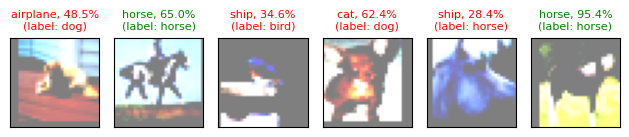

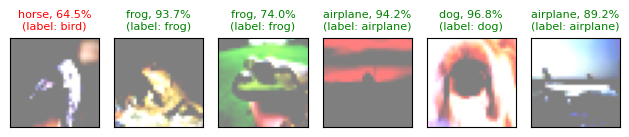

Epoch [32/100], Train Loss: 0.8582, Train Acc: 76.34%, Val Loss: 0.8992, Val Acc: 74.63%
Save the model and its state with the current best validation metric:  75.91666666666667
Epoch [33], Iteration [1], Loss: 0.8022
Epoch [33], Iteration [129], Loss: 0.8682
Epoch [33], Iteration [257], Loss: 0.8631
Epoch [33], Iteration [375], Loss: 0.6469


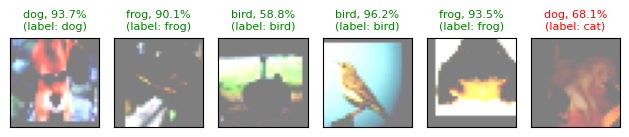

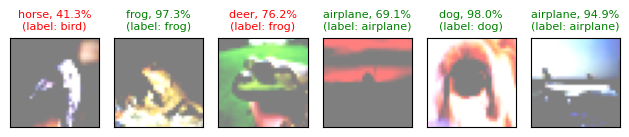

Epoch [33/100], Train Loss: 0.8518, Train Acc: 76.73%, Val Loss: 0.8648, Val Acc: 75.62%
Save the model and its state with the current best validation metric:  75.91666666666667
Epoch [34], Iteration [1], Loss: 0.8612
Epoch [34], Iteration [129], Loss: 0.9239
Epoch [34], Iteration [257], Loss: 0.9557
Epoch [34], Iteration [375], Loss: 0.6821


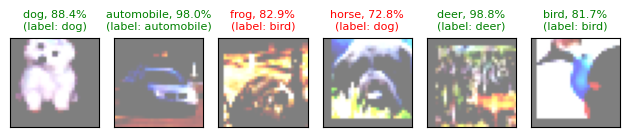

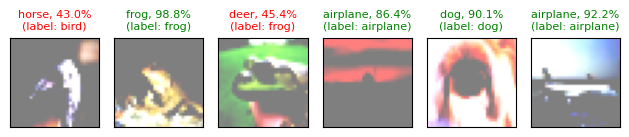

Epoch [34/100], Train Loss: 0.8467, Train Acc: 77.19%, Val Loss: 0.8837, Val Acc: 75.47%
Early stopping
Early Stopping Triggered - Training is Stopped - Best Checkpoint has been Saved!
Save the model and its state with the current best validation metric:  75.91666666666667


In [15]:
from torch.utils.data import DataLoader, ConcatDataset

cifar10_classes = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

learning_rate = 0.001
regression_lambda= 1e-4
filepath="/home/be/Desktop/PyTorch/runs/"

model=MyCNN()
import torch

# Assuming 'device' is either 'cuda' or 'cpu'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move your model to the device
model = model.to(device)

loss_func=GenericLoss(model, reg_lambda=regression_lambda)
optimizer= optim.Adam(model.parameters(), lr=learning_rate)

visualizer= Visualizer()

trainer= Trainer(model, train_loader, loss_func, optimizer, cifar10_classes, visualizer)
evaluator_val= Evaluator('val',model, val_loader, loss_func, cifar10_classes, visualizer)
evaluator_test= Evaluator('test',model,  test_loader, loss_func, cifar10_classes, visualizer)

writer= SummaryWriter(log_dir=filepath+'CIFAR-EXP-1')

early_stopping=EarlyStopping(filepath=filepath+'/checkpoints/', patience=5, minimize=False)

max_num_epoch=100

for epoch in range(max_num_epoch):
    train_loss, train_acc =trainer.train(epoch)
    
    val_loss, val_acc =evaluator_val.evaluate(epoch)
    
    print(f'Epoch [{epoch+1}/{max_num_epoch}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    early_stopping(val_acc, model)
    
    if early_stopping.early_stop:
        if early_stopping.early_stop:
            print("Early Stopping Triggered - Training is Stopped - Best Checkpoint has been Saved!")
            early_stopping.save_checkpoint(model)
            break
    else:
        early_stopping.save_checkpoint(model)
        

